# Importing packages and data

In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [2]:
data = pd.read_csv('Data Scientist Jobs/Processed_data.csv') # Preprocessed dataset
df = pd.read_csv('Data Scientist Jobs/DataScientist.csv', index_col = 0).drop('index', axis=1) # Original dataset
data

,Prompt,Target
0,Write a job description for AI Scientist role ...,Paige is a software company helping pathologis...
1,Write a job description for Quantitative Resea...,"About the Position\n\n\nAt Jane Street, we con..."
2,"Write a job description for VP, Data Science r...","We are looking for a VP, Data Science to lead ..."
3,Write a job description for Quantitative Resea...,Job Description\n\nQuantitative Researchers at...
4,Write a job description for Senior Data Engine...,"Key Responsibilities\n\n- Architect, build, an..."
...,...,...
1023,Write a job description for JPSC-7975 - Data A...,Overview\n\nRole: Data Analyst Lead – Informat...
1024,Write a job description for Principal Data Eng...,ComResource is looking for a Principal Data En...
1025,Write a job description for Columbus Data Scie...,#Columbus Data Science Tutor Jobs\n\nVarsity T...
1026,Write a job description for AWS Data Engineer ...,About Us\n\nTachyon Technologies is a Digital ...


# Modeling

In [3]:
from datasets import Dataset
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['Prompt', 'Target'],
    num_rows: 1028
})

In [4]:
# Train, validation split
datasets = dataset.train_test_split(train_size=0.8, seed=42)
datasets["validation"] = datasets.pop("test")
datasets

DatasetDict({
    train: Dataset({
        features: ['Prompt', 'Target'],
        num_rows: 822
    })
    validation: Dataset({
        features: ['Prompt', 'Target'],
        num_rows: 206
    })
})

In [5]:
# Load the Flan-t5-base model and tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorWithPadding, Trainer, TrainingArguments
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

In [6]:
# This is a function I used to tokenize the prompts and targets
def tokenize_function(example):
    """ Tokenize the 'prompt' and 'target' columns in the dataset """
    
    # Tokenize both 'prompt' and 'target' columns
    tokenized_prompt = tokenizer(example['Prompt'], truncation=True, padding=True)
    tokenized_target = tokenizer(example['Target'], truncation=True, padding='max_length', max_length=512)

    # Return a dictionary with the tokenized versions
    return {
        'input_ids': tokenized_prompt['input_ids'],
        'attention_mask': tokenized_prompt['attention_mask'],
        'labels': tokenized_target['input_ids']
    }

In [7]:
tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/206 [00:00<?, ? examples/s]

In [8]:
# Removing useless columns
tokenized_datasets = tokenized_datasets.remove_columns(['Prompt', 'Target'])
tokenized_datasets.set_format("torch")

In [9]:
tokenized_datasets["train"].column_names

['input_ids', 'attention_mask', 'labels']

In [10]:
tokenized_datasets["validation"].column_names

['input_ids', 'attention_mask', 'labels']

In [11]:
# Use my gpu to make training faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [12]:
# Creating the dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=2, collate_fn=data_collator
)
val_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [13]:
# Trying an example to make sure everything works fine (I am always afraid of errors :p)
for batch in train_dataloader:
    break
print({k: v.shape for k, v in batch.items()})
batch = {k: v.to(device) for k, v in batch.items()}

{'input_ids': torch.Size([2, 145]), 'attention_mask': torch.Size([2, 145]), 'labels': torch.Size([2, 512])}


In [14]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(31.9842, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([2, 512, 32128])


<b>Everything looks fine !!</b><br>
Let's build our training loop

In [15]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

C:\Users\ACER\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

4110


# Training

  0%|          | 0/4110 [00:00<?, ?it/s]

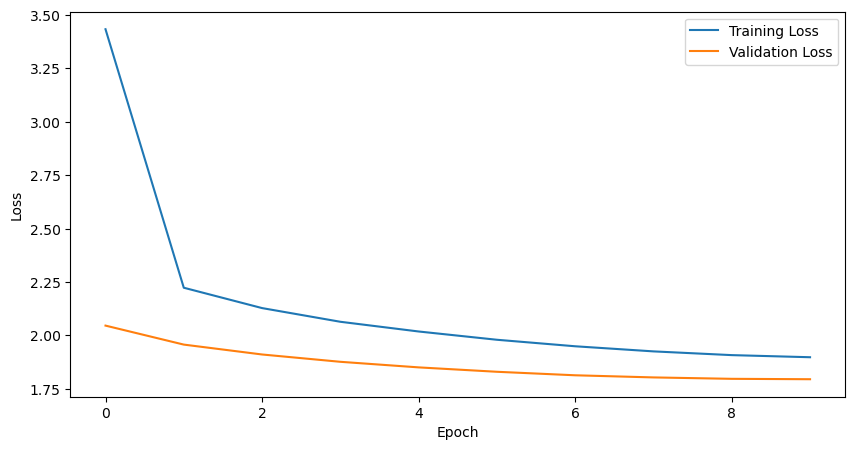

In [17]:
# Training loop

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
training_losses = []  # To store training losses
validation_losses = []  # To store validation losses

model.train()
for epoch in range(num_epochs):
    epoch_training_loss = 0.0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_training_loss += loss.item()

        progress_bar.update(1)

    # Calculate and record the average training loss for the epoch
    avg_training_loss = epoch_training_loss / len(train_dataloader)
    training_losses.append(avg_training_loss)

    # Calculate the validation loss at the end of each epoch
    model.eval()
    with torch.no_grad():
        epoch_validation_loss = 0.0
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_validation_loss += loss.item()

        avg_validation_loss = epoch_validation_loss / len(val_dataloader)
        validation_losses.append(avg_validation_loss)

    model.train()

# Plot the training and validation losses variation over the epochs
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Print the training and validation losses in a pandas dataframe format
display(pd.DataFrame({'epoch':[1,2,3,4,5,6,7,8,9,10], 'Training loss':training_losses, 'Validation loss':validation_losses}).set_index('epoch'))

,Training loss,Validation loss
epoch,,
1,3.433633,2.045535
2,2.222940,1.956597
3,2.127602,1.910281
4,2.063479,1.876020
5,2.017984,1.849883
6,1.979230,1.829282
7,1.948722,1.812848
8,1.924778,1.802867
9,1.907288,1.796283


# Test

In [20]:
def generate_description(prompt):
    """ It takes a prompt as input and return the job description"""
    # Encoding the prompt
    input_ids = tokenizer(prompt, return_tensors='pt', padding = True, truncation=True)['input_ids'].to(device)

    output = model.generate(input_ids, max_length=512) # generates an output

    # Decoding the output to get the generated text
    decoded_output = [tokenizer.decode(output[0], skip_special_tokens=True)][0]
    return decoded_output

In [30]:
# Testing a random prompt from the validation set
prompt = datasets['validation'][0]['Prompt']
description = generate_description(prompt)

print('prompt :')
print(prompt)
print(' ')
print("model's output :")
print(description[:-1960])

prompt :
Write a job description for VP, Data Science role proposed by "Park Data.", a company founded on 2012.0 that has now a size of 51 to 200 employees and works on Research & Development industry in the Business Services sector. The job proposed is in New York, NY meanwhile the headquarter of the company is in New York, NY. The salary estimate is $111K-$181K 
 
model's output :
Park Data is an Equal Opportunity employer. We hire women, men and minors to participate in all aspects of the workforce. We employ a diverse workforce to ensure that all qualified candidates are eligible for eligibility. We are committed to diversity and diversity in all our programs. We are looking for a talented, ambitious and motivated individual who is passionate about the work


In [31]:
# Testing another random prompt from the validation set
prompt = datasets['validation'][1]['Prompt']
description = generate_description(prompt)

print('prompt :')
print(prompt)
print(' ')
print("model's output :")
print(description)

prompt :
Write a job description for Senior Data Analyst role proposed by "Smith Hanley Associates.", a company founded on 1980.0 that has now a size of 1 to 50 employees and works on Staffing & Outsourcing industry in the Business Services sector. The job proposed is in Houston, TX meanwhile the headquarter of the company is in New York, 061. The salary estimate is $138K-$217K 
 
model's output :
Job Description Senior Data Analyst Location Houston, TX Duration: Fulltime - 12 Months Duration: Fulltime - 12 Months Duration: Full-time


In [32]:
# Testing a prompt that is not present even in the original dataset
df[df['Company Name'].str.contains('Google') & df['Job Title'].str.contains('Machine Learning intern')]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply


In [36]:
job_title = 'Machine Learning Intern'
company_name = 'Google'
year = 1998
size = '+200000 employees'
industry = 'IT Services industry'
sector = 'Information Technology'
location = 'New york, NY'
headquarter = 'California'
salary_estimate = '$50K-$100K'
prompt = f'Write a job description for {job_title} role proposed by "{company_name}", a company founded on {year} that has now a size of {size} and works on {industry} industry in the {sector} sector. The job proposed is in {location} meanwhile the headquarter of the company is in {headquarter}. The salary estimate is {salary_estimate}'
description = generate_description(prompt)

print('prompt :')
print(prompt)
print(' ')
print("model's output :")
print(description[:200])

prompt :
Write a job description for Machine Learning Intern role proposed by "Google", a company founded on 1998 that has now a size of +200000 employees and works on IT Services industry industry in the Information Technology sector. The job proposed is in New york, NY meanwhile the headquarter of the company is in California. The salary estimate is $50K-$100K
 
model's output :
Job Description Google Analytics is looking for a Machine Learning Intern to join their team. The ideal candidate will be a Data Scientist who will work on a variety of data analytics projects. The id
